In [35]:
import deepdish as dd
import os
import numpy as np
import pylab as plt
import seaborn as sns
import h5py
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
from glob import glob

In [36]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import sys
sys.path.append('../')
import detectors, detector_psds

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [38]:
data_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'

## Combine Data

### BNS

In [51]:
data_parts_files = glob(os.path.join(data_dir, 'simple_pe*','*part*.h5'))

total_data_dir = {}
data = dd.io.load(data_parts_files[0])
for key in data.keys():
    total_data_dir[key] = {}
    for param in data[key]:
        total_data_dir[key][param] = data[key][param]

for file in data_parts_files[1:]:
    data = dd.io.load(file)
    for key in data.keys():
        for param in data[key]:
            total_data_dir[key][param] = np.append(total_data_dir[key][param], data[key][param])
            
dd.io.save(os.path.join(data_dir, 'simple_pe_output_files', 'LHI_loc_results_1_pop_PL_spin_AU_z_MD_zmax_2_lmrd_106_366_days_corrected_td_combined.h5'), total_data_dir)

### NSBH

In [96]:
data_parts_files = glob(os.path.join(data_dir, 'SNR*', 'NSBH', '*part*.h5'))

total_data_dir = {}
data = dd.io.load(data_parts_files[0])
total_data_dir['config'] = data['config']

total_data_dir['Optimal_SNR'] = {}
for param in data['Optimal_SNR']:
    total_data_dir['Optimal_SNR'][param] = data['Optimal_SNR'][param]

for file in data_parts_files[1:]:
    data = dd.io.load(file)
    for param in data['Optimal_SNR']:
        total_data_dir['Optimal_SNR'][param] = np.append(total_data_dir['Optimal_SNR'][param], data['Optimal_SNR'][param])
total_data_dir['Optimal_SNR'] = pd.DataFrame(total_data_dir['Optimal_SNR'])
            
dd.io.save(os.path.join(data_dir, 'SNR_output_files', 'NSBH', 'LHI_SNR_1_pop_US_spin_prec_z_MD_zmax_2_lmrd_45_305_days_corrected_td_SNR_data_combined.h5'), total_data_dir)

/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'mass-model'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'mass-parameters'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/divyajyoti/miniconda3/envs/pycbc_pip/lib/python3.11/site-packages/tables/attributeset.py:462: NaturalNameWarning: object name is not a valid Python identifier: 'gps-start-time'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_

In [102]:
total_data_dir

{'config': {'Extrinsic': {},
  'Mass': {'mass-model': np.str_('UniformSecondary'),
   'mass-parameters': np.str_("{'alpha':3.37, 'beta': 0.76, 'delta_m':5.23, 'mmin':4.89, 'mmax':88.81, 'lam':0.04, 'mpp': 33.60, 'sigpp':4.59, 'minimum_secondary_mass': 1.0 , 'maximum_secondary_mass': 2.0}")},
  'Redshift': {'cosmology': np.str_('Planck18'),
   'duration': np.str_('5270400'),
   'gps-start-time': np.str_('1893024018'),
   'local-merger-rate-density': np.str_('45'),
   'maximum-redshift': np.str_('2'),
   'redshift-model': np.str_('MadauDickinson'),
   'redshift-parameters': np.str_('{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}')},
  'Spin': {'spin-model': np.str_('Isotropic-Bilby'),
   'spin-parameters': np.str_("{'minimum_primary_spin' : 0, 'maximum_primary_spin':  0.99, 'minimum_secondary_spin' : 0, 'maximum_secondary_spin' : 0.1}")}},
 'Optimal_SNR':        PSD_L1  PSD_H1  PSD_I1   spin1_a   spin2_a   chi_eff     chi_p  \
 0      ASharp  ASharp  ASharp  0.818534  0.089484 -0.597136  0.

## Function definitions

In [39]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [40]:
def bin_style(hist_data):
    if len(hist_data)>100:
        bs = 'sqrt'
    else:
        if len(hist_data)>50:
            bs = 'auto'
        else:
            bs = len(hist_data)//3
            if bs==0:
                bs=1
    return(bs)

In [41]:
def plot_efficiency_curve(selected_data, total_data, bins='sqrt', **kwargs):
    ns_sel, bins_sel = np.histogram(selected_data, bins=bins)
    ns_tot, bins_tot = np.histogram(total_data, bins=bins_sel)
    if not np.all(bins_sel == bins_tot):
        raise ValueError("Bins are not equal! Something went wrong.")
    eff_samples = ns_sel/ns_tot
    #plt.bar(bins_sel[:-1], eff_samples, np.diff(bins_sel), **kwargs)
    
    # Using plt.step to create a step-like plot
    line = plt.stairs(eff_samples, bins_sel, **kwargs)
    return(eff_samples, bins_sel)

In [42]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

def load_h5_data_to_dict(h5_file):
    data_dict = {}
    with h5py.File(h5_file, 'r') as f:
        for key in f.keys():
            item = f[key]
            if isinstance(item, h5py.Dataset):
                val = item[()]
                data_dict[key] = decode_bytes_recursive(val)
            elif isinstance(item, h5py.Group):
                data_dict[key] = load_h5_group(item)
    return(data_dict)

## BBH

### A-sharp

In [43]:
data_dir_bbh = os.path.join(data_dir, 'SNR_output_files', 'BBH')

In [44]:
data_file = glob(os.path.join(data_dir_bbh, 'LHI*.h5'))
print(data_file)
with h5py.File(data_file[0], 'r') as f:
    print(f['Optimal_SNR'].keys())

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/SNR_output_files/BBH/LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5']
<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values']>


In [45]:
bbh_data = dd.io.load(data_file[0])
snr_data_bbh = bbh_data['Optimal_SNR']
snr_data_bbh['comoving_distance'] = cosmo.comoving_distance(snr_data_bbh['redshift'])
config_bbh = bbh_data['config']

In [46]:
bbh_data['Optimal_SNR'].keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network', 'comoving_distance'],
      dtype='object')

In [16]:
detected_bbh = {'all':{}, 'network':{}, 'two-detector':{}}
for method in detected_bbh.keys():
    detected_bbh[method] = get_detected_SNRs(snr_data_bbh, method=method)

Text(0, 0.5, 'Events / year')

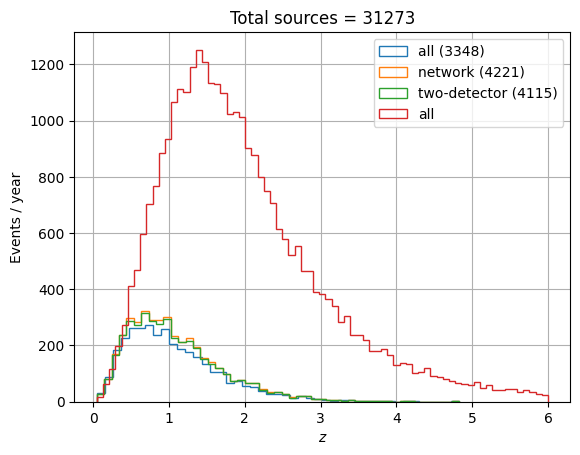

In [16]:
for key in detected_bbh.keys():
    bbh_data = detected_bbh[key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{key} ({len(bbh_data["redshift"])})', bins='auto')
plt.hist(snr_data_bbh['redshift'], histtype=u'step', label='all', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["mass1"])}')
plt.grid()
plt.xlabel('$z$')
plt.ylabel('Events / year')

In [18]:
mass_cut = detected_bbh['two-detector']['mtotal']>50
mass_cut_total = snr_data_bbh['mtotal'] >50

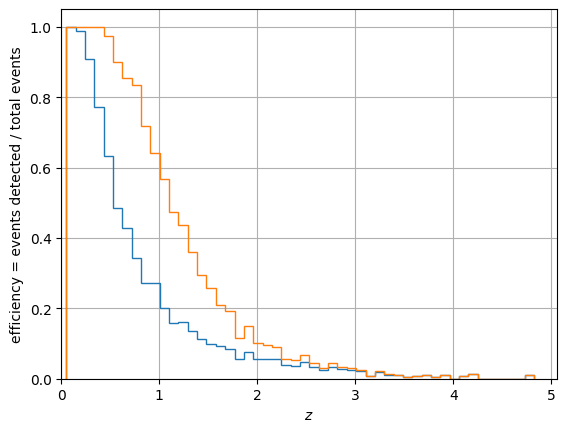

In [19]:
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'], snr_data_bbh['redshift'], bins=50, zorder=2)
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'][mass_cut], 
                             snr_data_bbh['redshift'][mass_cut_total], bins=50, zorder=2)
#plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

### XG

In [48]:
data_dir_bbh = os.path.join(data_dir, 'SNR_output_files', 'BBH')

In [49]:
data_file_xg = glob(os.path.join(data_dir_bbh, 'CE4020ET123*.h5'))
print(data_file)

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/SNR_output_files/BBH/LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5']


In [54]:
bbh_data_xg = load_h5_data_to_dict(data_file_xg[0])
snr_data_bbh_xg = pd.DataFrame(bbh_data_xg['results'])
snr_data_bbh_xg['comoving_distance'] = cosmo.comoving_distance(snr_data_bbh_xg['redshift'])
config_bbh = bbh_data_xg['config']

In [55]:
bbh_data_xg['results'].keys()

dict_keys(['PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3', 'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time'])

In [56]:
detected_bbh_xg = {'all':{}, 'network':{}, 'two-detector':{}}
for method in detected_bbh_xg.keys():
    detected_bbh_xg[method] = get_detected_SNRs(snr_data_bbh_xg, method=method)

Text(0, 0.5, 'Events / year')

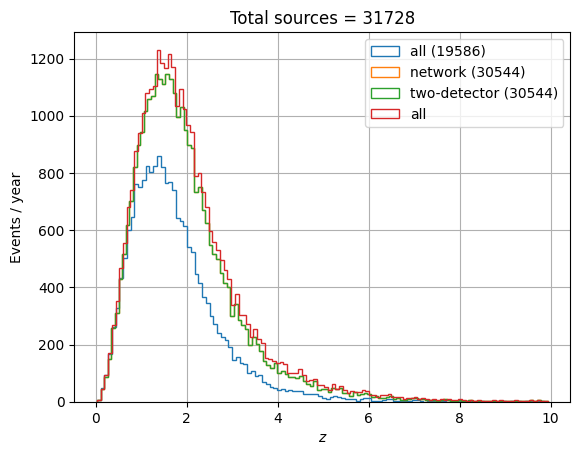

In [57]:
for key in detected_bbh_xg.keys():
    bbh_data_xg = detected_bbh_xg[key]
    plt.hist(bbh_data_xg['redshift'], histtype=u'step', 
             label=f'{key} ({len(bbh_data_xg["redshift"])})', bins='auto')
plt.hist(snr_data_bbh_xg['redshift'], histtype=u'step', label='all', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh_xg["mass1"])}')
plt.grid()
plt.xlabel('$z$')
plt.ylabel('Events / year')

### Plot A-sharp and XG for slides

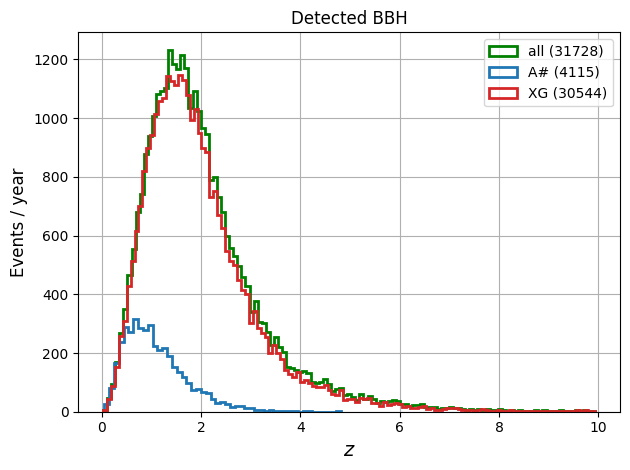

In [90]:
plt.hist(snr_data_bbh_xg['redshift'], histtype=u'step', label=f'all ({len(snr_data_bbh_xg["mass1"])})', 
         bins='auto', linewidth=2, color='g')
plt.hist(detected_bbh['two-detector']['redshift'], histtype=u'step', 
         label=f'A# ({len(detected_bbh["two-detector"]["redshift"])})', bins='auto', linewidth=2)
plt.hist(detected_bbh_xg['two-detector']['redshift'], histtype=u'step', color='tab:red',
         label=f'XG ({len(detected_bbh_xg["two-detector"]["redshift"])})', bins='auto', linewidth=2)
plt.legend()
plt.title('Detected BBH')
plt.grid()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('Events / year', fontsize=12)
plt.tight_layout()
plt.savefig('Asharp_XG_all_detected_events_z.png', dpi=300)

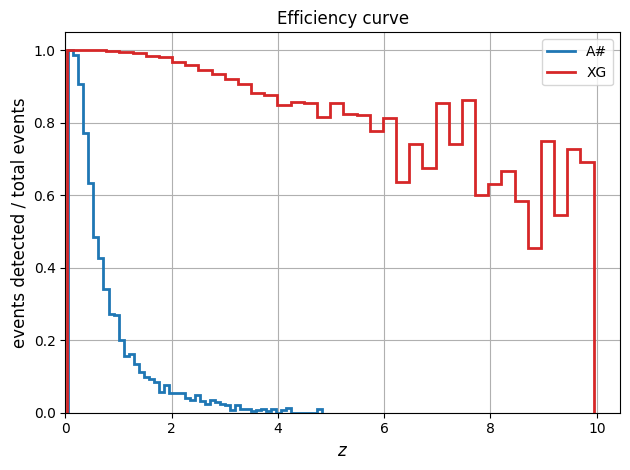

In [91]:
vals = plot_efficiency_curve(detected_bbh['two-detector']['redshift'], snr_data_bbh['redshift'], 
                             bins=50, zorder=2, linewidth=2, label='A#')
vals = plot_efficiency_curve(detected_bbh_xg['two-detector']['redshift'], snr_data_bbh_xg['redshift'], 
                             bins=40, zorder=2, linewidth=2, color='tab:red', label='XG')
#plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$', fontsize=12)
plt.ylabel('events detected / total events', fontsize=12)
plt.grid()
plt.title('Efficiency curve')
plt.legend()
plt.tight_layout()
plt.savefig('efficiency_curve_Asharp_XG.png', dpi=300)

#### SNRs

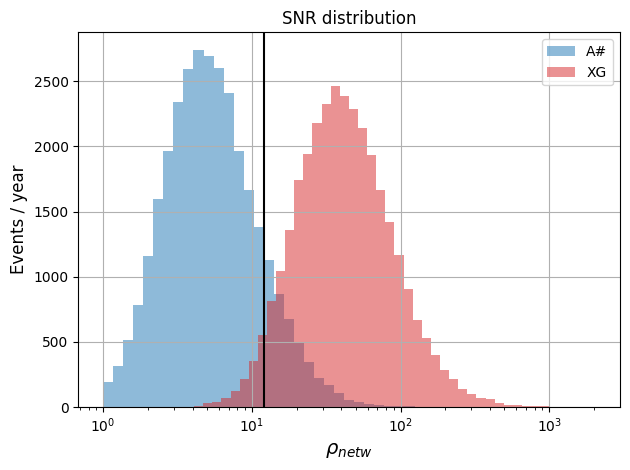

In [191]:
max_SNR = max(snr_data_bbh_xg['SNR_network'])
plt.hist(snr_data_bbh['SNR_network'], label='A#', alpha=0.5,
         bins=np.logspace(0, np.log10(max_SNR), num=50), color='tab:blue')
plt.hist(snr_data_bbh_xg['SNR_network'], label='XG', alpha=0.5, 
         bins=np.logspace(0, 3, num=50), color='tab:red')
plt.legend()
plt.grid()
plt.xlabel('$\\rho_{netw}$', fontsize=14)
plt.ylabel('Events / year', fontsize=12)
plt.xscale('log')
plt.axvline(12, c='k')
plt.title('SNR distribution')
plt.tight_layout()
plt.savefig('Asharp_XG_SNR_dist.png', dpi=300)

#### Fisher Matrix errors

In [113]:
fm_errors_file = glob(os.path.join(data_dir, 'GWBench_analysis', 'BBH', 'LHI*no_spins.h5'))[0]
fm_errors_file_xg = glob(os.path.join(data_dir, 'GWBench_analysis', 'BBH', 'CE4020ET123*no_spins.h5'))[0]

In [157]:
fm_errors = {'errs':{'log_DL':{}, 
                     'DL':{}}, 
             'inj_params':{'DL':{}, 
                           'z':{}}}
for netw, file in zip(['A#', 'XG'], [fm_errors_file, fm_errors_file_xg]):
    with h5py.File(file, 'r') as f:
        fm_errors['errs']['log_DL'][netw] = np.array([f['errs'][event]['log_DL'][()] for event in f['errs'].keys()])
        for inj_param in fm_errors['inj_params'].keys():
            fm_errors['inj_params'][inj_param][netw] = \
                np.array([f['inj_params'][event][inj_param][()] for event in f['inj_params'].keys()])
        fm_errors['errs']['DL'][netw] = fm_errors['errs']['log_DL'][netw]*fm_errors['inj_params']['DL'][netw]

In [158]:
with h5py.File(file, 'r') as f:
    print(f['inj_params']['0'].keys())

<KeysViewHDF5 ['DL', 'Mc', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'eta', 'iota', 'phic', 'psi', 'ra', 'tc', 'z']>


In [159]:
def print_dict_tree(d, indent=0):
    if isinstance(d, dict):
        for key, value in d.items():
            print("  " * indent + str(key))
            print_dict_tree(value, indent + 1)
    elif isinstance(d, list):
        for i, item in enumerate(d):
            print("  " * indent + f"[{i}]")
            print_dict_tree(item, indent + 1)
print_dict_tree(fm_errors)

errs
  log_DL
    A#
    XG
  DL
    A#
    XG
inj_params
  DL
    A#
    XG
  z
    A#
    XG


In [160]:
from scipy.interpolate import UnivariateSpline
def calc_dz_dDL(z_arr, DL_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)

    Returns:
    --------------------------
    delta_z_arr: dz_dDL : scipy.interpolate.UnivariateSpline
        Derivative spline giving dz/dDL
    """
    
    sort_idx = np.argsort(DL_arr)
    DL_sorted = DL_arr[sort_idx]
    z_sorted = z_arr[sort_idx]
    
    fz = UnivariateSpline(DL_sorted, z_sorted)
    dfz_dDL = fz.derivative()
    return(dfz_dDL)

In [161]:
def get_delta_z_from_delta_DL(dfz_dDL, DL_arr, delta_DL_arr):
    """
    Parameters: 
    ----------------------
    dfz_dDL: scipy.interpolate
        Derivative function for dz/dDL
    DL_arr: numpy array
        Luminosity distance (Mpc)
    delta_DL_arr: numpy array
        errors on DL

    Returns:
    --------------------------
    delta_z_arr: numpy array
        error on z
    """
    
    delta_z = dfz_dDL(DL_arr) * delta_DL_arr
    return(delta_z)

In [164]:
fm_errors['errs']['z'] = {}
fm_errors['errs']['log_z'] = {}
for netw, data in zip(['A#', 'XG'], [snr_data_bbh, snr_data_bbh_xg]):
    dfz_dDL_interp = calc_dz_dDL(data['redshift'], data['distance'])
    fm_errors['errs']['z'][netw] = get_delta_z_from_delta_DL(dfz_dDL_interp, 
                                                             fm_errors['inj_params']['DL'][netw], 
                                                             fm_errors['errs']['DL'][netw])
    fm_errors['errs']['log_z'][netw] = fm_errors['errs']['z'][netw]/fm_errors['inj_params']['z'][netw]

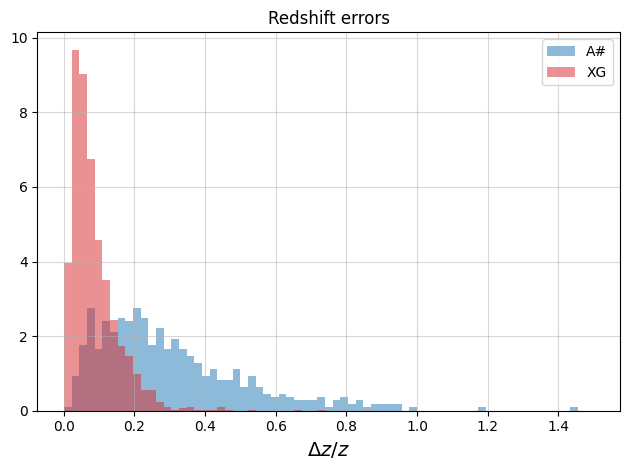

In [190]:
plt.hist(fm_errors['errs']['log_z']['A#'], bins=np.linspace(0, 1.5, 70), label='A#', alpha=0.5, density=True)
plt.hist(fm_errors['errs']['log_z']['XG'], bins=np.linspace(0, 1.5, 70), label='XG', 
         alpha=0.5, color='tab:red', density=True)
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('$\Delta z/z$', fontsize=14)
plt.title('Redshift errors')
plt.tight_layout()
plt.savefig('z_errors_Asharp_XG.png', dpi=300)

### gwpopulation corner

In [200]:
from bilby.core.result import plot_multiple
from bilby.core.result import read_in_result
import h5py
from glob import glob

In [199]:
gwpop_results_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results'

In [211]:
gwpop_result_files = {'A#':glob(os.path.join(gwpop_results_dir, 'Asharp', '*mf*', '*hdf5'))[0], 
                      'XG':glob(os.path.join(gwpop_results_dir, 'CE4020ET123', '*mf*', '*hdf5'))[0]}

In [212]:
gwpop_results = {}
for netw, file in gwpop_result_files.items():
    gwpop_results[netw] = read_in_result(file)

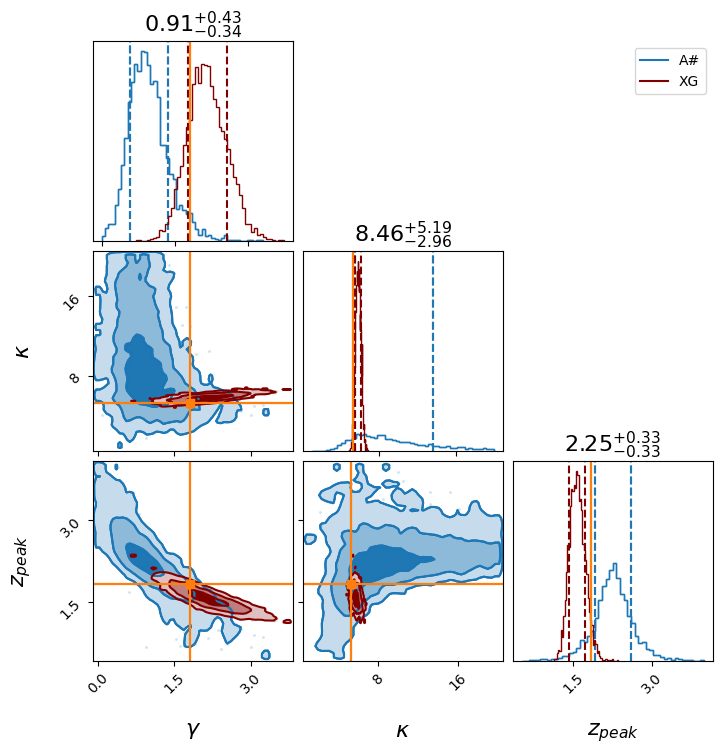

In [216]:
plot_multiple(list(gwpop_results.values()), filename='corner_Asharp_XG.png', 
              labels=['A#', 'XG'], 
              colours=['tab:blue', 'maroon'], 
              save=True, parameters={'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}, 
              smooth=True, filled=False);

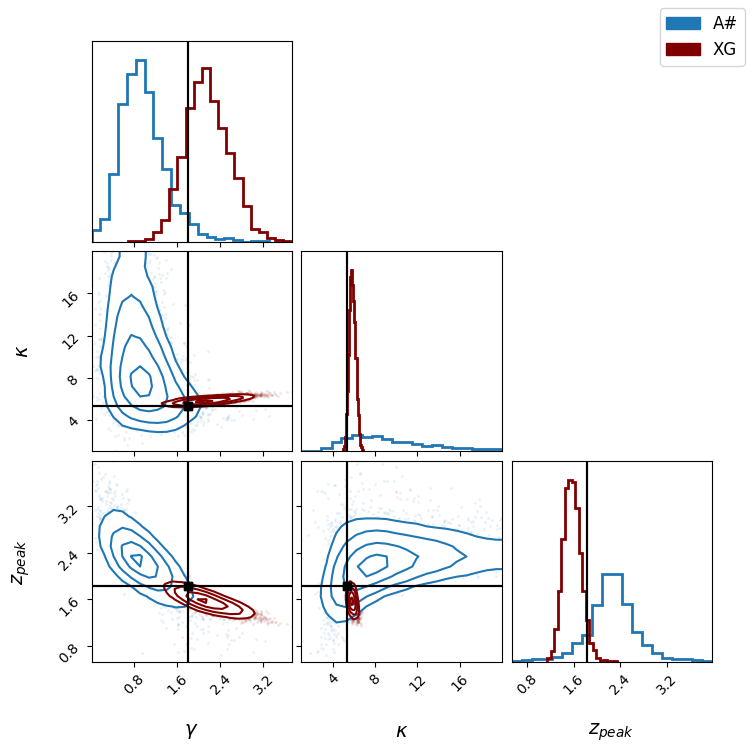

In [228]:
import corner
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming `gwpop_results` is an OrderedDict of bilby `Result` objects
results = list(gwpop_results.values())
labels = ['A#', 'XG']
colors = ['tab:blue', 'maroon']
params_to_plot = ['gamma', 'kappa', 'z_peak']
truths = {'gamma': 1.8032, 'kappa': 5.3023, 'z_peak': 1.8362}

fig = None

for result, label, color in zip(results, labels, colors):
    data = result.posterior[params_to_plot].values
    fig = corner.corner(
        data,
        fig=fig,
        labels=['$\gamma$', '$\kappa$', '$z_{peak}$'],
        truths=[truths[p] for p in params_to_plot],
        label_kwargs={'fontsize': 14},
        color=color,
        plot_contours=True,
        fill_contours=False,
        smooth=1.0,
        plot_density=False,
        hist_kwargs={'density': True, 'linewidth':2},
        contour_kwargs={'linewidths': 1.5},
        truth_color='black'
    )

handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the figure
fig.legend(
    handles=handles,
    loc='upper right',
    fontsize=12,
    frameon=True,
)
plt.savefig("corner_Asharp_XG.png", dpi=300)

### Mass populations

In [20]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [21]:
detect_type = 'two-detector'
mass_pops_bbh = {}

for m_range in ['<10', '10-30', '30-70', '>70']:
    mass_pops_bbh[m_range] = {}
    for pop, input_dfs_dict in zip(['detected', 'total'], [detected_bbh[detect_type], snr_data_bbh]):
        mass_pops_bbh[m_range][pop] = {}
        for netw in input_dfs_dict.keys():
            bool_arr = slice_mtotal_pop(input_dfs_dict['srcmtotal'], m_range)
            mass_pops_bbh[m_range][pop] = input_dfs_dict[bool_arr]

In [22]:
input_dfs_dict.keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network', 'comoving_distance'],
      dtype='object')

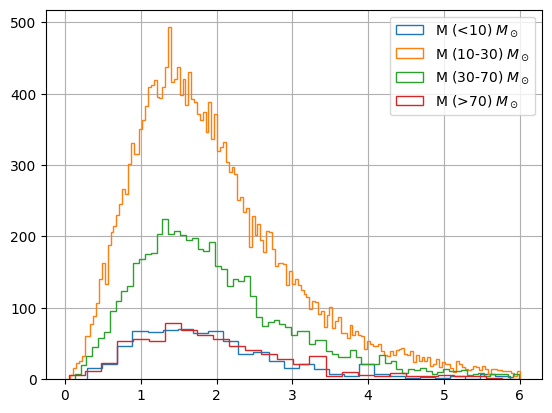

In [23]:
plt.figure()
for m_range, color in zip(mass_pops_bbh.keys(), colors):
    hist_data = mass_pops_bbh[m_range]['total']['redshift']
    plt.hist(hist_data, bins='sqrt', histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
#plt.title(netw_labels[netw])
plt.legend()
plt.grid()

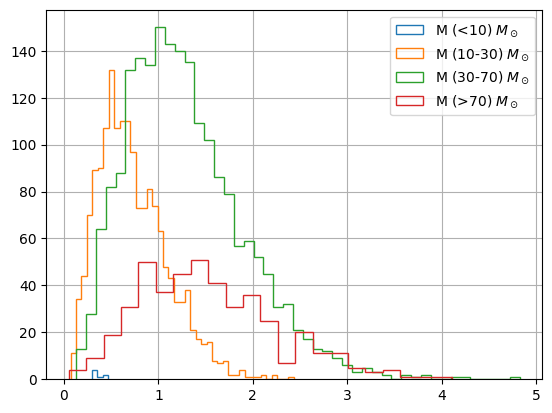

In [24]:
plt.figure()
for m_range, color in zip(mass_pops_bbh.keys(), colors):
    hist_data = mass_pops_bbh[m_range]['detected']['redshift']
    plt.hist(hist_data, bins='sqrt', histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
#plt.title(netw_labels[netw])
plt.legend()
plt.grid()

Text(0.5, 1.0, '30 < M < 70')

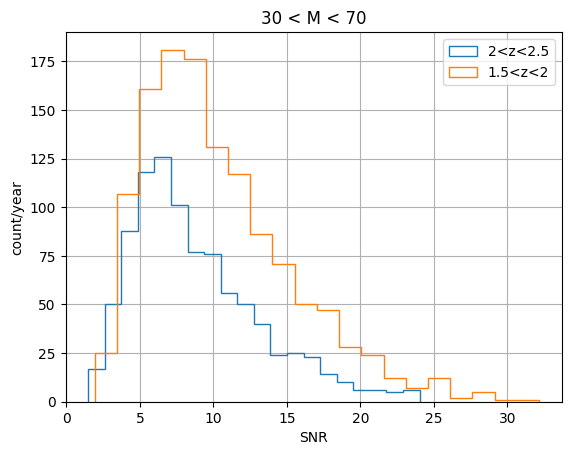

In [25]:
# This is first time we'll be seeing over the SFR peak with a few events which are detectable
plt.hist(mass_pops_bbh['30-70']['total']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['redshift'] < 2.5, 
                                                                      mass_pops_bbh['30-70']['total']['redshift'] > 2), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2<z<2.5');
plt.hist(mass_pops_bbh['30-70']['total']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['redshift'] < 2, 
                                                                      mass_pops_bbh['30-70']['total']['redshift'] > 1.5), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='1.5<z<2');
plt.xlabel('SNR')
plt.grid()
plt.ylabel('count/year')
plt.legend()
plt.title('30 < M < 70')

## NSBH

In [29]:
data_dir_nsbh = os.path.join(data_dir, 'SNR_output_files', 'NSBH')

In [30]:
data_file = glob(os.path.join(data_dir_nsbh, '*combined*.h5'))
print(data_file)
nsbh_data = dd.io.load(data_file[0])
snr_data_nsbh = nsbh_data['Optimal_SNR']
snr_data_nsbh['comoving_distance'] = cosmo.comoving_distance(snr_data_nsbh['redshift'])
config_nsbh = nsbh_data['config']

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/SNR_output_files/NSBH/LHI_SNR_1_pop_US_spin_prec_z_MD_zmax_2_lmrd_45_305_days_corrected_td_SNR_data_combined.h5']


In [31]:
detected_nsbh = {'all':{}, 'network':{}, 'two-detector':{}}
for method in detected_nsbh.keys():
    detected_nsbh[method] = get_detected_SNRs(snr_data_nsbh, method=method)

Text(0, 0.5, 'Events / year')

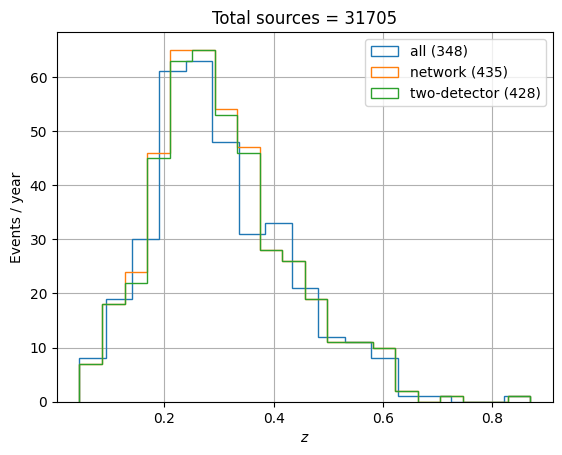

In [32]:
for key in detected_nsbh.keys():
    nsbh_data = detected_nsbh[key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{key} ({len(nsbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["mass1"])}')
plt.grid()
plt.xlabel('$z$')
plt.ylabel('Events / year')